# Recommendation System with Collaborative Filtering
## Description

Content discovery helps users explore the content they would like to consume. Currently, we manually curate the content into each row then present it to the users. However, we are now growing as a business. Users come and experience our services every day, so we need your help!

Let's build a recommender system based on users' behaviors to recommend the content. As a Machine Learning Engineer, in this project, you need to develop a recommender system, starting from data preparation, model development, model deployment, and API service.



## Import importance library 

In [82]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

## Load the data 

In [78]:
ratings = pd.read_csv('../data/ratings.csv')
# Drop the timestamp column
ratings = ratings.drop(columns=['timestamp'])

The dataset contains the following descriptive statistics for the columns `userId`, `movieId`, and `rating`:

In [79]:
ratings.head()

,userId,movieId,rating
0,1.0,1.0,4.0
1,1.0,3.0,4.0
2,1.0,6.0,4.0
3,1.0,47.0,5.0
4,1.0,50.0,5.0


In [80]:
ratings.describe()

,userId,movieId,rating
count,99032.000000,100836.000000,100836.000000
mean,327.736368,19435.295718,3.752177
std,182.869519,35530.987199,4.306037
min,1.000000,1.000000,-8.000000
25%,177.000000,1199.000000,3.000000
50%,328.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,99.000000


### Observations:

1. **User IDs (`userId`)**:
   - The user IDs range from 1 to 610.
   - The distribution of user IDs appears to be fairly uniform.

2. **Movie IDs (`movieId`)**:
   - The movie IDs range from 1 to 193,609.
   - This indicates a large number of unique movies in the dataset.

3. **Ratings (`rating`)**:
   - The ratings should typically be within the range of 0.0 to 5.0.
   - However, the minimum rating is -8.0 and the maximum rating is 99.0.
   - These values indicate the presence of outliers or incorrect data entries.
   - The mean rating is 3.75, which is within the expected range, but the standard deviation of 4.31 suggests a significant spread in the ratings.

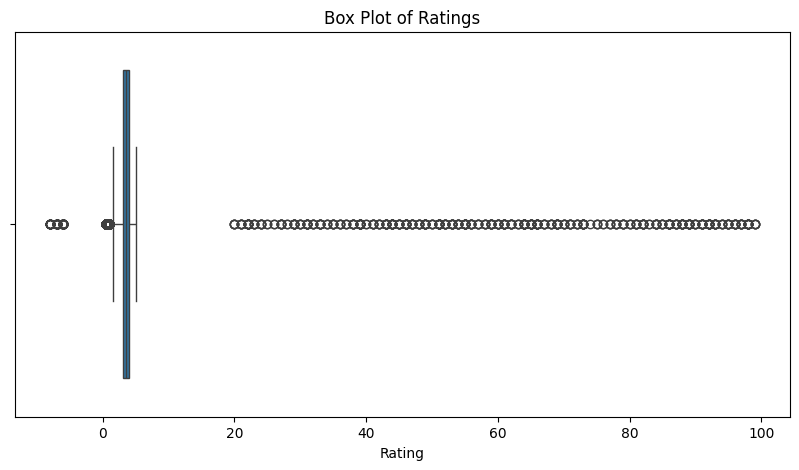

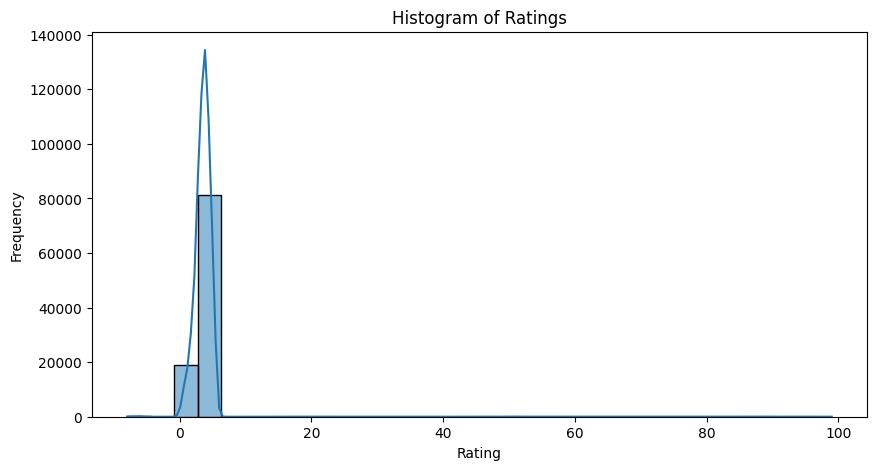

Total number of ratings: 100836
Number of outliers: 568
Percentage of outliers: 0.56%


In [84]:
# Identify outliers
outliers = ratings[(ratings['rating'] < 0.0) | (ratings['rating'] > 5.0)]
non_outliers = ratings[(ratings['rating'] >= 0.0) & (ratings['rating'] <= 5.0)]

# Visualize the data with a box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x=ratings['rating'])
plt.title('Box Plot of Ratings')
plt.xlabel('Rating')
plt.show()

# Visualize the data with a histogram
plt.figure(figsize=(10, 5))
sns.histplot(ratings['rating'], bins=30, kde=True)
plt.title('Histogram of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Quantify the impact of outliers
total_ratings = ratings.shape[0]
total_outliers = outliers.shape[0]
outlier_percentage = (total_outliers / total_ratings) * 100

print(f"Total number of ratings: {total_ratings}")
print(f"Number of outliers: {total_outliers}")
print(f"Percentage of outliers: {outlier_percentage:.2f}%")

let's find the list of missing values 

In [71]:
unique_userIds = ratings['userId'].unique()
unique_userIds = unique_userIds[~np.isnan(unique_userIds)]

# Generate a list of all expected userIds based on the range of observed userIds
expected_userIds = range(int(unique_userIds.min()), int(unique_userIds.max()) + 1)

# Find missing userIds
missing_userIds = [userId for userId in expected_userIds if userId not in unique_userIds]
# find the index that has the missing number
index_with_none = ratings[ratings['userId'].isna()].index.tolist()


In [72]:
print(f"missing UserID : {missing_userIds}\nindex of all missing number : {index_with_none}")

missing UserID : [3, 41, 67, 96, 119, 130, 143, 158, 192, 229, 259, 268, 275, 283, 431, 434, 458, 468, 481, 502]
index of all missing number : [261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 5658, 5659, 5660, 5661, 5662, 5663, 5664, 5665, 5666, 5667, 5668, 5669, 5670, 5671, 5672, 5673, 5674, 5675, 5676, 5677, 5678, 5679, 5680, 5681, 5682, 5683, 5684, 5685, 5686, 5687, 5688, 5689, 5690, 5691, 5692, 5693, 5694, 5695, 5696, 5697, 5698, 5699, 5700, 5701, 5702, 5703, 5704, 5705, 5706, 5707, 5708, 5709, 5710, 5711, 5712, 5713, 5714, 5715, 5716, 5717, 5718, 5719, 5720, 5721, 5722, 5723, 5724, 5725, 5726, 5727, 5728, 5729, 5730, 5731, 5732, 5733, 5734, 5735, 5736, 5737, 5738, 5739, 5740, 5741, 5742, 5743, 5744, 5745, 5746, 5747, 5748, 5749, 5750, 5751, 5752, 5753, 5754, 5755, 5756, 5757, 5758, 5759, 5760, 5761, 5762, 5763, 5764, 5765, 5766, 5767, 5

In [74]:
ratings[ratings['userId'] == 3.0]

,userId,movieId,rating


In [75]:
def fill_ranges(indices, values):
    # Initialize variables to track continuous ranges
    start = indices[0]
    prev = indices[0]
    ranges = []

    # Find continuous ranges of indices
    for i in range(1, len(indices)):
        if indices[i] != prev + 1:
            ranges.append((start, prev))
            start = indices[i]
        prev = indices[i]
    ranges.append((start, prev))

    # Fill ranges with specified values
    for i, (start, end) in enumerate(ranges):
        fill_value = values[i % len(values)]
        ratings.loc[start:end, 'userId'] = fill_value

# List of indices
# indices = [22, 23, 24, 25, 26, 27, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

# # Values to fill
# values = [44, 1010101010]

# Fill ranges with values
fill_ranges(index_with_none, missing_userIds)

# Print the updated DataFrame
print(ratings)

        userId   movieId  rating
0          1.0       1.0     4.0
1          1.0       3.0     4.0
2          1.0       6.0     4.0
3          1.0      47.0     5.0
4          1.0      50.0     5.0
...        ...       ...     ...
100831   610.0  166534.0     4.0
100832   610.0  168248.0     5.0
100833   610.0  168250.0     5.0
100834   610.0  168252.0     5.0
100835   610.0  170875.0     3.0

[100836 rows x 3 columns]
